In [19]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertModel
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [20]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])


In [21]:
ratingsnew = ratings_.head(10000)
# ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1))

                  user_id             business_id stars  \
0  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   3.0   

                                                text  
0  [CLS] If you decide to eat here , just be awar...  


In [22]:
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


/tmp/ipykernel_34204/2687010449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
/tmp/ipykernel_34204/2687010449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [23]:
sparse_item_user = sparse.csr_matrix((df_features['stars'].astype('float'), (df_features['user_id'], df_features['business_id'])))
sparse_user_item = sparse.csr_matrix((df_features['stars'].astype('float'),  (df_features['business_id'],df_features['user_id'])))


In [7]:
%pip install implicit

     |████████████████████████████████| 18.6 MB 6.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
import implicit

In [25]:
modelRec = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)


alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')


modelRec.fit(data_conf)


100%|██████████| 20/20 [00:00<00:00, 239.02it/s]


In [26]:
df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)
df_features.head()

/tmp/ipykernel_34204/3483575756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)


,user_id,business_id,stars,text,labels
0,7445,2091,3.0,"[CLS] If you decide to eat here , just be awar...","[-0.19312422, 1.4302356, 0.08076221, -1.12314,..."
1,3849,525,5.0,[CLS] I ' ve taken a lot of spin classes over ...,"[-0.78198993, -1.1078973, -1.738901, 1.8977867..."
2,1395,2179,3.0,[CLS] Family diner . Had the b ##uff ##et . E ...,"[0.044064663, -0.012546215, -0.029700937, 0.06..."
3,5467,2992,5.0,"[CLS] Wow ! Yu ##mmy , different , delicious ....","[-1.6785535, -1.1172565, 1.0333899, 0.7713539,..."
4,5864,2555,4.0,[CLS] Cut ##e interior and owner ( ? ) gave us...,"[-1.1951275, -0.54739237, -0.59064925, -0.8023..."


In [28]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)
y_train = tf.convert_to_tensor(
     train_df["labels"].tolist(), dtype=float
)

y_test = tf.convert_to_tensor(
     test_df["labels"].tolist(), dtype=float
)



In [29]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilBert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [30]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [31]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [32]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [33]:
max_len = 512
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = distilBert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'linear')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [34]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = MeanSquaredError()
metric = MeanSquaredError()
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [MeanSquaredError(),MeanAbsolutePercentageError()])

In [35]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
223/223 [==============================] - 2515s 11s/step - loss: 1.1166 - mean_squared_error: 1.1176 - mean_absolute_percentage_error: 9530848.0000 - val_loss: 1.1109 - val_mean_squared_error: 1.1106 - val_mean_absolute_percentage_error: 7921848.5000
Epoch 2/2
223/223 [==============================] - 2589s 12s/step - loss: 1.1061 - mean_squared_error: 1.1067 - mean_absolute_percentage_error: 9114881.0000 - val_loss: 1.1099 - val_mean_squared_error: 1.1097 - val_mean_absolute_percentage_error: 8715877.0000


In [36]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

250/250 [==============================] - 757s 3s/step


array([ 0.17562425,  0.21331733,  0.22370252,  0.10455251,  0.08392686,
       -0.0259592 , -0.07337038,  0.1773848 ,  0.169066  ,  0.27645284,
        0.0563214 ,  0.10964622,  0.32643956,  0.0913451 ,  0.3241963 ,
        0.19452006,  0.3270937 ,  0.1747783 ,  0.20886016,  0.318964  ],
      dtype=float32)

In [37]:
y_train[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.61601144,  1.289281  , -1.1007904 ,  1.8023819 , -0.5949579 ,
       -0.3603471 ,  0.47645456,  1.8105932 ,  1.5537475 ,  0.12308085,
        0.7750955 , -0.48037013, -0.42177597, -1.861378  , -1.3506731 ,
       -1.4087504 ,  0.8619918 ,  0.70339555,  1.7222025 ,  1.2666596 ],
      dtype=float32)>

In [38]:
train_history.history

{'loss': [1.1165986061096191, 1.10605788230896],
 'mean_squared_error': [1.1176252365112305, 1.1067001819610596],
 'mean_absolute_percentage_error': [9530848.0, 9114881.0],
 'val_loss': [1.1108729839324951, 1.1099187135696411],
 'val_mean_squared_error': [1.1105958223342896, 1.1096798181533813],
 'val_mean_absolute_percentage_error': [7921848.5, 8715877.0]}

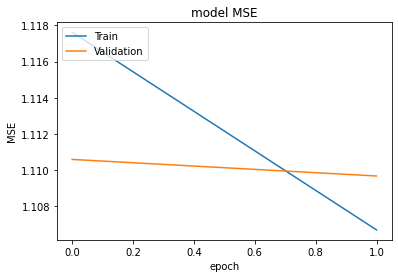

In [39]:
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
user_id = test_df['user_id'].tolist()[0]
print(user_id)

2583


In [41]:
newVector = np.array(predicted_raw[0])
print(newVector)
modelRec.user_factors[user_id]

[ 0.17562425  0.21331733  0.22370252  0.10455251  0.08392686 -0.0259592
 -0.07337038  0.1773848   0.169066    0.27645284  0.0563214   0.10964622
  0.32643956  0.0913451   0.3241963   0.19452006  0.3270937   0.1747783
  0.20886016  0.318964  ]


array([ 1.3430897 , -0.46454692,  1.7118365 , -0.9350982 ,  0.746847  ,
        1.9420581 ,  2.2403789 , -1.4276997 , -0.31267834,  0.7888094 ,
        2.0714645 ,  0.47798777,  0.90224963, -1.16656   , -0.98620564,
        0.972289  , -0.46800002, -1.0406213 , -0.43034008, -1.4140073 ],
      dtype=float32)

In [42]:
modelRec.recommend(user_id,data_conf[user_id], N = 20)

(array([ 486, 1010, 2911, 2868, 2718, 1831, 2538,   30, 1392, 2552, 3448,
        3075, 1985,  994,  998, 3056, 3015, 3183, 3795, 1007], dtype=int32),
 array([0.5212387 , 0.5117135 , 0.4938407 , 0.4567606 , 0.45177245,
        0.4482859 , 0.442662  , 0.42060283, 0.4130694 , 0.41081816,
        0.4088124 , 0.40622464, 0.40348092, 0.40318942, 0.40000814,
        0.390729  , 0.38689443, 0.3819231 , 0.38155636, 0.37364548],
       dtype=float32))

In [43]:
modelRec.user_factors[user_id] = newVector
print(modelRec.recommend(user_id,data_conf[user_id], N =20))

(array([3653, 1052,  982,  752, 1540, 1743, 2880, 3286, 3185, 2293,  900,
       1431, 2866,  926, 1267, 2223,  241,  277, 1291,   30], dtype=int32), array([0.11908435, 0.10963389, 0.09277611, 0.08502308, 0.08236465,
       0.08231629, 0.08119047, 0.07468513, 0.07388086, 0.07215826,
       0.07070549, 0.0701668 , 0.07007919, 0.06980097, 0.06683615,
       0.06559658, 0.06544447, 0.06316205, 0.06219524, 0.0612511 ],
      dtype=float32))
